In [1]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import uproot
import numpy as np
import awkward as ak
from torch.utils.data import DataLoader
import torch
import datetime
import numpy as np
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
# PyTorch Lightning
import pytorch_lightning as L
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, RichProgressBar
from torchmetrics.classification import BinaryConfusionMatrix

In [2]:
import uproot
### Energy = 0.15 GeV

root_file1 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF1.root")
root_file2 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF2.root")
tree1 = root_file1["Samples"]
tree2 = root_file2["Samples"]
arrays1 = tree1.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise", "waveform", "PUOnlywaveform"])
arrays2 = tree2.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise", "PUOnlywaveform"])
X_real = ak.to_numpy(arrays1["samples"])
X_real = X_real/np.max(X_real, axis = 1).reshape(200000,1)
y_real = ak.to_numpy(arrays1["ysamples"])
X_noise = ak.to_numpy(arrays2["samplesNoise"])
X_noise = X_noise/np.max(X_noise, axis = 1).reshape(200000,1)
y_noise = ak.to_numpy(arrays2["ysamplesNoise"])
X_waveform = ak.to_numpy(arrays1["waveform"]) + ak.to_numpy(arrays1["PUOnlywaveform"])
X_waveform = X_waveform / np.max(X_waveform, axis = 1).reshape(200000,1)
X_Zero = np.zeros((X_waveform.shape[0], X_waveform.shape[1]), dtype=float)

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
#data = X_real
labels = np.concatenate([y_real,y_noise])
#labels = y_real
X_target = np.concatenate([X_waveform, X_Zero])
#X_target = X_waveform
# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning

shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]
X_target = X_target[shuffle_indices]

[[-2.18991428 -1.33758012 -0.16379419 ...  0.97133729  0.38098346
  -1.97539871]
 [-0.02620282  0.3494965   0.54694886 ...  0.55314748  0.19741884
  -0.15557223]
 [ 0.70501369  0.95452037  1.         ...  0.82044019  0.71309163
   0.61413221]
 ...
 [-0.03224206 -0.11911494  0.25985249 ...  0.45905995  0.7742844
   1.        ]
 [ 0.42559843  0.71037992  0.30653368 ...  0.96303223  1.
   0.64932407]
 [-0.13804387  0.03573051 -0.07850811 ...  0.81263918  0.81864257
   0.44620173]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [3]:
import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
valid_size = train_size + int(0.1 * num_events_data)
valid_size_down = train_size - int(0.1 * num_events_data)
train_data = data[:train_size]
train_labels = labels[:train_size]
train_target = X_target[:train_size]

valid_data = data[valid_size_down:valid_size]
valid_labels = labels[valid_size_down:valid_size]
valid_target = X_target[valid_size_down:valid_size]

test_data = data[valid_size:]
test_labels = labels[valid_size:]
test_target = X_target[valid_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : validation data: {len(data)} : {len(train_data)} : {len(test_data)} : {len(valid_data)}')

number of rows in data is 400000
number of rows in data is 10
Size of training data is 200000
number of elements in data : training data : test data : validation data: 400000 : 200000 : 160000 : 80000


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [5]:
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
valid_data = valid_data.reshape((valid_data.shape[0], valid_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], 1))
test_labels = test_labels.reshape((test_labels.shape[0], 1))
valid_labels = valid_labels.reshape((valid_labels.shape[0], 1))
train_target = train_target.reshape((train_target.shape[0], train_target.shape[1],1))
test_target = test_target.reshape((test_target.shape[0], test_target.shape[1],1))
valid_target = valid_target.reshape((valid_target.shape[0], valid_target.shape[1],1))

In [6]:
train_data = torch.tensor(train_data, dtype =torch.float).to(device)
test_data = torch.tensor(test_data, dtype =torch.float).to(device)
valid_data = torch.tensor(valid_data, dtype =torch.float).to(device)
train_labels = torch.tensor(train_labels, dtype =torch.float).to(device)
test_labels = torch.tensor(test_labels, dtype =torch.float).to(device)
valid_labels = torch.tensor(valid_labels, dtype =torch.float).to(device)
train_target = torch.tensor(train_target, dtype =torch.float).to(device)
test_target = torch.tensor(test_target, dtype =torch.float).to(device)
valid_target = torch.tensor(valid_target, dtype =torch.float).to(device)

In [7]:
class TransformerDataset(Dataset):
    """
    Dataset class used for transformer models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        target: torch.tensor,
        device
        ) -> None:
        
        super().__init__()

        self.data = data
        self.target = target
        self.device = device

        print("data size = {}".format(data.size()))
        print("target size = {}".format(target.size()))
            

    def __len__(self):
        
        return self.data.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        src = self.data[index]
        
        start_token = 99.*torch.ones((self.target.size()[0],1,1)).to(self.device)
        target = torch.cat((start_token, self.target),1)[index]
        
        trg = target[:-1,:]
        trg_y = target[1:,:]
        

        return src, trg, trg_y

In [8]:
training_data = TransformerDataset(
    data = train_data,
    target = train_target,
    device = device)

data size = torch.Size([200000, 10, 1])
target size = torch.Size([200000, 10, 1])


In [9]:
testing_data = TransformerDataset(
    data = test_data,
    target = test_target,
    device = device)

data size = torch.Size([160000, 10, 1])
target size = torch.Size([160000, 10, 1])


In [10]:
validing_data = TransformerDataset(
    data = valid_data,
    target = valid_target,
    device = device)

data size = torch.Size([80000, 10, 1])
target size = torch.Size([80000, 10, 1])


In [11]:
batch_size=128
# Load the training data
training_dataloader = DataLoader(training_data, batch_size= batch_size, drop_last = True)
# Load the testing data
testing_dataloader = DataLoader(testing_data, batch_size= batch_size, drop_last = True)
# Load the validing data
validing_dataloader = DataLoader(validing_data, batch_size= batch_size, drop_last = True)

In [12]:
class PositionalEncoder(nn.Module):

    def __init__(
        self, 
        dropout: float=0.1, 
        max_seq_len: int=10, 
        d_model: int=512,
        batch_first: bool=True
        ):

        """
        Parameters:
            dropout: the dropout rate
            max_seq_len: the maximum length of the input sequences
            d_model: The dimension of the output of sub-layers in the model 
        """

        super().__init__()

        self.d_model = d_model
        
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first

        # adapted from PyTorch tutorial
        position = torch.arange(max_seq_len).unsqueeze(1)
        
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        if self.batch_first:
            pe = torch.zeros(1, max_seq_len, d_model)
            
            pe[0, :, 0::2] = torch.sin(position * div_term)
            
            pe[0, :, 1::2] = torch.cos(position * div_term)
        else:
            pe = torch.zeros(max_seq_len, 1, d_model)
        
            pe[:, 0, 0::2] = torch.sin(position * div_term)
        
            pe[:, 0, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, enc_seq_len, dim_val] or 
               [enc_seq_len, batch_size, dim_val]
        """
        if self.batch_first:
            x = x + self.pe[:,:x.size(1)]
        else:
            x = x + self.pe[:x.size(0)]

        return self.dropout(x)

In [13]:
def generate_square_subsequent_mask(dim1: int, dim2: int, device) -> Tensor:
    """
    Args:

        dim1: int,  target sequence length

        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 


    Return:

        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1).to(device)

In [15]:
class TimeSeriesTransformer(L.LightningModule):

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        batch_size: int,
        out_seq_len: int=10,
        dim_val: int=32,  
        n_encoder_layers: int=2,
        n_decoder_layers: int=2,
        n_heads: int=8,
        dropout_encoder: float=0.2, 
        dropout_decoder: float=0.2,
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        dim_feedforward_decoder: int=2048,
        lr = 0.0001,
        output_sequence_length: int = 10
        ): 

        super().__init__() 
        self.save_hyperparameters()
        self._create_model()
        self.eval_loss = []

    def _create_model(self):
        
        # Creating the three linear layers needed for the model
        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=self.hparams.input_size, 
            out_features=self.hparams.dim_val 
            )

        self.decoder_input_layer = nn.Linear(
            in_features=self.hparams.input_size,
            out_features=self.hparams.dim_val
            )  
        
        self.linear_mapping = nn.Linear(
            in_features=self.hparams.dim_val, 
            out_features=self.hparams.input_size
            )

        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=self.hparams.dim_val,
            dropout=self.hparams.dropout_pos_enc
            )

        # Creating the encoder layer 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hparams.dim_val, 
            nhead=self.hparams.n_heads,
            dim_feedforward=self.hparams.dim_feedforward_encoder,
            dropout=self.hparams.dropout_encoder,
            batch_first=self.hparams.batch_first
            )

        # Stack the encoder layers in nn.TransformerEncoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=self.hparams.n_encoder_layers, 
            norm=None
            )

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=self.hparams.dim_val,
            nhead=self.hparams.n_heads,
            dim_feedforward=self.hparams.dim_feedforward_decoder,
            dropout=self.hparams.dropout_decoder,
            batch_first=self.hparams.batch_first
            )

        # Stack the decoder layers in nn.TransformerDecoder
        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=self.hparams.n_decoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor, tgt: Tensor, src_mask: Tensor=None, 
                tgt_mask: Tensor=None) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            tgt: the sequence to the decoder. Shape: 
                 (T, N, E)(T,N,E) if batch_first=False or (N, T, E) if 
                 batch_first=True, where T is the target sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
            src_mask: the mask for the src sequence to prevent the model from 
                      using data points from the target sequence
            tgt_mask: the mask for the tgt sequence to prevent the model from
                      using data points from the target sequence
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        #print("From model.forward(): tgt size = {}".format(tgt.size()))

        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder

        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))

        # Pass decoder input through decoder input layer
        decoder_output = self.decoder_input_layer(tgt) # src shape: [target sequence length, batch_size, dim_val] regardless of number of input features
        #print("From model.forward(): Size of decoder_output after linear decoder layer: {}".format(decoder_output.size()))

        #if src_mask is not None:
            #print("From model.forward(): Size of src_mask: {}".format(src_mask.size()))
        #if tgt_mask is not None:
            #print("From model.forward(): Size of tgt_mask: {}".format(tgt_mask.size()))

        # Pass throguh decoder - output shape: [batch_size, target seq len, dim_val]
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
            )

        #print("From model.forward(): decoder_output shape after decoder: {}".format(decoder_output.shape))

        # Pass through linear mapping
        decoder_output = self.linear_mapping(decoder_output) # shape [batch_size, target seq len]
        #print("From model.forward(): decoder_output size after linear_mapping = {}".format(decoder_output.size()))

        return decoder_output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        # We don't return the lr scheduler because we need to apply it per iteration, not per epoch
        #self.lr_scheduler = L.LightningModule.CosineWarmupScheduler(
        #    optimizer, warmup=self.hparams.warmup, max_iters=self.hparams.max_iters
        #)
        return optimizer
    
    #def optimizer_step(self, *args, **kwargs):
        #super().optimizer_step(*args, **kwargs)
        #self.lr_scheduler.step()  # Step per iteration
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def on_validation_epoch_end(self):
        raise NotImplementedError

In [16]:
def run_encoder_decoder_inference(
    model, 
    src: torch.Tensor, 
    batch_size: int,
    device,
    output_sequence_length: int,
    batch_first: bool=True
    ) -> torch.Tensor:

    """ 
    Args:
        model: An encoder-decoder type model where the decoder requires
               target values as input. Should be set to evaluation mode before 
               passed to this function.
               
        src: The input to the model
        
        output_sequence_length: The desired length of the model's output
        
        batch_size: batch size
        
        batch_first: If true, the shape of the model input should be 
                     [batch size, input sequence length, number of features].
                     If false, [input sequence length, batch size, number of features]
    
    """

    # Dimension of a batched model input that contains the target sequence values
    target_seq_dim = 0 if batch_first == False else 1

    # Take the last value of thetarget variable in all batches in src and make it tgt
    # as per the Influenza paper
    tgt = 99.0*torch.ones(1, batch_size, 1).to(device) if batch_first == False else 99.0*torch.ones(batch_size, 1, 1).to(device) # shape [1, batch_size, 1]

    # Iteratively concatenate tgt with the first element in the prediction
    for _ in range(output_sequence_length-1):

        # Create masks
        dim_a = tgt.shape[1] if batch_first == True else tgt.shape[0]

        dim_b = src.shape[1] if batch_first == True else src.shape[0]

        tgt_mask = generate_square_subsequent_mask(
            dim1=dim_a,
            dim2=dim_a,
            device = device
            )

        src_mask = generate_square_subsequent_mask(
            dim1=dim_a,
            dim2=dim_b,
            device = device
            )

        # Make prediction
        prediction = model(src, tgt, src_mask, tgt_mask) 

        # If statement simply makes sure that the predicted value is 
        # extracted and reshaped correctly
        if batch_first == False:

            # Obtain the predicted value at t+1 where t is the last time step 
            # represented in tgt
            last_predicted_value = prediction[-1, :, :] 

            # Reshape from [batch_size, 1] --> [1, batch_size, 1]
            last_predicted_value = last_predicted_value.unsqueeze(0)

        else:

            # Obtain predicted value
            last_predicted_value = prediction[:, -1, :]

            # Reshape from [batch_size, 1] --> [batch_size, 1, 1]
            last_predicted_value = last_predicted_value.unsqueeze(-1)

        # Detach the predicted element from the graph and concatenate with 
        # tgt in dimension 1 or 0
        tgt = torch.cat((tgt, last_predicted_value.detach()), target_seq_dim)
    
    # Create masks
    dim_a = tgt.shape[1] if batch_first == True else tgt.shape[0]

    dim_b = src.shape[1] if batch_first == True else src.shape[0]

    tgt_mask = generate_square_subsequent_mask(
        dim1=dim_a,
        dim2=dim_a,
        device=device
        )

    src_mask = generate_square_subsequent_mask(
        dim1=dim_a,
        dim2=dim_b,
        device=device
        )

    # Make final prediction
    final_prediction = model(src, tgt, src_mask, tgt_mask)

    return final_prediction

In [18]:
class Train_TimeSeriesClassifier(TimeSeriesTransformer):
    
    def _calculate_loss(self, batch):
        
        # Fetch data and transform categories to one-hot vectors
        src, trg, trg_y = batch
        criterion = torch.nn.MSELoss()
        
        # Make src mask for decoder with size:
        # [batch_size*n_heads, output_sequence_length, enc_seq_len]
        src_mask = generate_square_subsequent_mask(
            dim1=self.hparams.output_sequence_length,
            dim2=self.hparams.dec_seq_len,
            device = device 
            
            )

        # Make tgt mask for decoder with size:
        # [batch_size*n_heads, output_sequence_length, output_sequence_length]
        tgt_mask = generate_square_subsequent_mask( 
            dim1=self.hparams.output_sequence_length,
            dim2=self.hparams.output_sequence_length,
            device = device
            )
        
        prediction = self.forward(src, trg, src_mask=src_mask, tgt_mask=tgt_mask)
        
        # Compute loss and accuracy 
        loss = criterion(prediction, trg_y)
        
        return loss
    
    def _calculate_loss_test(self, batch, mode="val"):
        
        # Fetch data and transform categories to one-hot vectors
        src, _, trg_y = batch
        criterion = torch.nn.MSELoss()
        
        prediction = run_encoder_decoder_inference(
                self, 
                src=src, 
                batch_size= self.hparams.batch_size,
                device = device,
                output_sequence_length = self.hparams.output_sequence_length
                )
        
        # Compute loss and accuracy 
        loss = criterion(prediction, trg_y)
       
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch)
        self.log("ptl/train_loss", loss)
        print("validation loss -------->", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._calculate_loss_test(batch)
        self.eval_loss.append(loss)
        return {"val_loss": loss}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.eval_loss).mean()
        self.log("ptl/val_loss", avg_loss, sync_dist=True)
        print("validation loss -------->", avg_loss)
        self.eval_loss.clear()

    

In [19]:
dec_seq_len = 10 # length of input given to decoder
enc_seq_len = 10 # length of input given to encoder
# initialize checkpoints
early_stop = EarlyStopping(monitor="ptl/val_loss", patience=3, mode="min", min_delta = 0.0001)
checkpoint_callback = ModelCheckpoint(save_weights_only=True, monitor="ptl/val_loss", mode="min")
progress_bar = RichProgressBar(leave=True)

trainer = L.Trainer(
        default_root_dir="/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/",
        callbacks=[early_stop, checkpoint_callback, progress_bar ],
        accelerator="gpu",
        devices=1,
        max_epochs=5,
        #gradient_clip_val=5,
    )
print(batch_size)
model = Train_TimeSeriesClassifier(
           input_size=1,
           dec_seq_len=enc_seq_len,
           batch_first=True,
           batch_size = batch_size
           )

trainer.fit(model, training_dataloader, validing_dataloader)

# Test best model on validation and test set
#val_result = trainer.test(model, dataloaders=validing_dataloader, verbose=False)
#test_result = trainer.test(model, dataloaders=testing_dataloader, verbose=False)
#result = {"test_loss": test_result[0]["test_loss"], "val_loss": val_result[0]["test_loss"]}
model = model.to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


128


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder_input_layer       │ Linear             │     64 │
│ 1 │ decoder_input_layer       │ Linear             │     64 │
│ 2 │ linear_mapping            │ Linear             │     33 │
│ 3 │ positional_encoding_layer │ PositionalEncoder  │      0 │
│ 4 │ encoder                   │ TransformerEncoder │  275 K │
│ 5 │ decoder                   │ TransformerDecoder │  283 K │
└───┴───────────────────────────┴────────────────────┴────────┘

Trainable params: 558 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 558 K                                                                                                
Total estimated model params size (MB): 2

Output()

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/t
rainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many 
workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is 
the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/nn/modules/ac
tivation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect 
performance. Prefer to use a boolean mask directly. (Triggered internally at 
/build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/torch-2.0.1p1/src/torch/2.0.1p1/aten/src/ATen/nativ
e/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(

validation loss --------> tensor(0.3664, device='cuda:0')

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/t
rainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many 
workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is 
the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

validation loss --------> tensor(0.4754, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2322, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2823, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2926, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.3076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2367, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1879, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1760, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1626, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1807, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1851, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1951, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1435, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1428, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1317, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1250, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1235, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1340, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1293, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.1106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0995, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0987, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0902, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0926, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0910, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0904, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0928, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0841, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0705, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0748, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0759, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0724, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0767, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0718, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0695, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0683, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0704, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0647, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0637, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0572, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0553, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0633, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0624, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0574, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0535, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0589, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0567, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0582, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0583, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0601, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0520, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0502, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0574, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0542, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0545, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0471, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0556, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0509, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0442, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0524, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0493, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0502, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0485, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0473, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0435, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0442, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0513, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0474, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0494, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0452, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0463, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0433, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0446, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0470, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0411, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0437, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0426, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0465, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0455, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0414, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0449, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0452, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0437, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0430, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0420, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0459, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0479, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0446, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0442, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0478, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0423, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0441, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0372, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0424, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0392, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0445, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0382, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0413, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0438, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0384, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0368, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0400, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0428, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0385, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0382, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0422, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0362, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0380, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0366, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0424, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0355, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0393, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0425, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0376, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0398, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0389, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0364, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0333, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0406, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0374, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0387, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0382, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0341, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0393, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0412, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0381, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0399, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0369, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0401, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0375, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0410, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0360, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0334, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0386, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0357, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0326, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0346, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0364, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0347, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0364, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0318, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0383, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0391, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0384, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0354, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0348, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0373, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0359, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0402, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0333, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0338, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0324, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0352, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0351, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0323, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0305, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0294, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0356, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0345, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0332, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0330, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0358, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0335, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0313, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0331, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0343, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0314, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0321, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0312, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0302, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0391, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0327, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0349, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0356, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0278, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0317, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0320, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0328, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0310, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0297, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0319, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0300, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0283, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0288, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0272, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0298, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0303, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0311, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0306, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0271, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0257, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0280, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0285, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0277, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0338, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0255, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0281, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0269, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0299, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0309, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0290, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0284, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0287, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0301, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0265, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0259, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0289, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0276, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0273, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0256, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0270, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0258, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0266, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0245, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0261, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0268, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0240, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0260, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0262, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0250, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0253, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0247, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0252, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0246, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0248, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0243, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0225, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0244, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0234, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0293, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0230, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0237, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0242, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0228, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0216, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0210, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0218, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0236, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0251, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0212, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0198, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0233, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0223, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0215, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0219, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0211, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0206, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0224, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0209, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0204, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0221, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0201, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0214, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0227, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0213, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0222, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0189, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0231, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0200, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0208, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0185, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0202, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0187, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0186, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0194, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0181, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2483, device='cuda:0')

Output()

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0188, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0167, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0183, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0175, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0176, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0193, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0170, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0190, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0195, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0153, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0184, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0157, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2117, device='cuda:0')

Output()

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0154, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0152, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2309, device='cuda:0')

Output()

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0062, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2176, device='cuda:0')

Output()

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0138, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0059, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0149, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0134, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

validation loss --------> tensor(0.2318, device='cuda:0')

`Trainer.fit` stopped: `max_epochs=5` reached.


In [20]:
model

Train_TimeSeriesClassifier(
  (encoder_input_layer): Linear(in_features=1, out_features=32, bias=True)
  (decoder_input_layer): Linear(in_features=1, out_features=32, bias=True)
  (linear_mapping): Linear(in_features=32, out_features=1, bias=True)
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [21]:
model = model.to(device)

In [22]:
torch.save(model, "/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/Transformer_Encoder_Decoder_NetworkV1.pt")

In [23]:
model.eval()

Train_TimeSeriesClassifier(
  (encoder_input_layer): Linear(in_features=1, out_features=32, bias=True)
  (decoder_input_layer): Linear(in_features=1, out_features=32, bias=True)
  (linear_mapping): Linear(in_features=32, out_features=1, bias=True)
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): 

In [24]:
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [ ]:
log_dir = "/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/lightning_logs/version_5"
val_key = "ptl/val_loss"
train_key = 'ptl/train_loss'

In [ ]:
event_accumulator = EventAccumulator(log_dir)
event_accumulator.Reload()

In [ ]:
steps = {x.step for x in event_accumulator.Scalars("epoch")}
x = list(range(len(steps)-1))
val_loss = [x.value for x in event_accumulator.Scalars(val_key) if x.step in steps]
train_loss = [x.value for x in event_accumulator.Scalars(train_key) if x.step in steps]

In [ ]:
# Plot accuracy
plt.plot(val_loss)
plt.plot(train_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([ 'Validation', 'Train'], loc='upper left')
plt.show()

In [ ]:
trainer.checkpoint_callback.best_model_path

In [ ]:
best_model = Train_TimeSeriesClassifier.load_from_checkpoint('/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/lightning_logs/version_5/checkpoints/epoch=2-step=2343.ckpt')

In [ ]:
trainer.test(best_model, dataloaders=testing_dataloader, verbose=True)

In [25]:
model1 = model.to(device)

In [26]:
# Initialize a list to store predictions
predictions = []
# Iterate through the test DataLoader and make predictions
with torch.no_grad():
    
        for j, (src, _, tgt_y) in enumerate(testing_dataloader):
            #print(src.size())
            outputs = run_encoder_decoder_inference(
                model=model, 
                src=src, 
                batch_size=batch_size,
                device = device,
                output_sequence_length = 10
                )
            predictions.append(outputs)
            print("iteration--->",j)
            #print(tgt_y)
            #print(outputs)
            

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /build/jenkins/workspace/lcg_release_pipeline/build/pyexternals/torch-2.0.1p1/src/torch/2.0.1p1/aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


iteration---> 0
iteration---> 1
iteration---> 2
iteration---> 3
iteration---> 4
iteration---> 5
iteration---> 6
iteration---> 7
iteration---> 8
iteration---> 9
iteration---> 10
iteration---> 11
iteration---> 12
iteration---> 13
iteration---> 14
iteration---> 15
iteration---> 16
iteration---> 17
iteration---> 18
iteration---> 19
iteration---> 20
iteration---> 21
iteration---> 22
iteration---> 23
iteration---> 24
iteration---> 25
iteration---> 26
iteration---> 27
iteration---> 28
iteration---> 29
iteration---> 30
iteration---> 31
iteration---> 32
iteration---> 33
iteration---> 34
iteration---> 35
iteration---> 36
iteration---> 37
iteration---> 38
iteration---> 39
iteration---> 40
iteration---> 41
iteration---> 42
iteration---> 43
iteration---> 44
iteration---> 45
iteration---> 46
iteration---> 47
iteration---> 48
iteration---> 49
iteration---> 50
iteration---> 51
iteration---> 52
iteration---> 53
iteration---> 54
iteration---> 55
iteration---> 56
iteration---> 57
iteration---> 58
iterati

iteration---> 462
iteration---> 463
iteration---> 464
iteration---> 465
iteration---> 466
iteration---> 467
iteration---> 468
iteration---> 469
iteration---> 470
iteration---> 471
iteration---> 472
iteration---> 473
iteration---> 474
iteration---> 475
iteration---> 476
iteration---> 477
iteration---> 478
iteration---> 479
iteration---> 480
iteration---> 481
iteration---> 482
iteration---> 483
iteration---> 484
iteration---> 485
iteration---> 486
iteration---> 487
iteration---> 488
iteration---> 489
iteration---> 490
iteration---> 491
iteration---> 492
iteration---> 493
iteration---> 494
iteration---> 495
iteration---> 496
iteration---> 497
iteration---> 498
iteration---> 499
iteration---> 500
iteration---> 501
iteration---> 502
iteration---> 503
iteration---> 504
iteration---> 505
iteration---> 506
iteration---> 507
iteration---> 508
iteration---> 509
iteration---> 510
iteration---> 511
iteration---> 512
iteration---> 513
iteration---> 514
iteration---> 515
iteration---> 516
iteration-

iteration---> 918
iteration---> 919
iteration---> 920
iteration---> 921
iteration---> 922
iteration---> 923
iteration---> 924
iteration---> 925
iteration---> 926
iteration---> 927
iteration---> 928
iteration---> 929
iteration---> 930
iteration---> 931
iteration---> 932
iteration---> 933
iteration---> 934
iteration---> 935
iteration---> 936
iteration---> 937
iteration---> 938
iteration---> 939
iteration---> 940
iteration---> 941
iteration---> 942
iteration---> 943
iteration---> 944
iteration---> 945
iteration---> 946
iteration---> 947
iteration---> 948
iteration---> 949
iteration---> 950
iteration---> 951
iteration---> 952
iteration---> 953
iteration---> 954
iteration---> 955
iteration---> 956
iteration---> 957
iteration---> 958
iteration---> 959
iteration---> 960
iteration---> 961
iteration---> 962
iteration---> 963
iteration---> 964
iteration---> 965
iteration---> 966
iteration---> 967
iteration---> 968
iteration---> 969
iteration---> 970
iteration---> 971
iteration---> 972
iteration-

In [27]:
len(predictions)


1250

In [28]:
predictions[0].size()

torch.Size([128, 10, 1])

In [29]:
testing_Sigdata1 = torch.flatten(torch.stack([x for x in predictions]), end_dim = 1)

In [30]:
testing_Sigdata1.size()

torch.Size([160000, 10, 1])

In [31]:
size = int(testing_Sigdata1.size()[0]*0.6)
size

96000

In [32]:
testing_Sigdata = testing_Sigdata1[size:]
training_Sigdata = testing_Sigdata1[:size]

In [33]:
class ClassifierDataset(Dataset):
    """
    Dataset class used for classifier models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        label: torch.tensor
        ) -> None:
        
        super().__init__()

        self.data = data
        self.label = label

        print("data size = {}".format(data.size()))
        print("target size = {}".format(label.size()))
            

    def __len__(self):
        
        return self.data.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        data = self.data[index]
        label = self.label[index]
        return data, label

In [34]:
training_Sigclass = ClassifierDataset(
    data = training_Sigdata ,
    label = test_labels[:size])

data size = torch.Size([96000, 10, 1])
target size = torch.Size([96000, 1])


In [35]:
testing_Sigclass = ClassifierDataset(
    data = testing_Sigdata,
    label = test_labels[size:])

data size = torch.Size([64000, 10, 1])
target size = torch.Size([64000, 1])


In [36]:
class TimeSeriesBiClassifier(L.LightningModule):

    def __init__(self, 
        input_size: int,
        dec_seq_len: int,
        batch_first: bool,
        dim_val: int=512,  
        n_encoder_layers: int=1,
        n_heads: int=32,
        dropout_encoder: float=0.2, 
        dropout_pos_enc: float=0.1,
        dim_feedforward_encoder: int=2048,
        lr = 0.0003517
        ): 

        """
        Args:
            input_size: int, number of input variables. 1 if univariate.
            dec_seq_len: int, the length of the input sequence fed to the decoder
            dim_val: int, aka d_model. All sub-layers in the model produce 
                     outputs of dimension dim_val
            n_encoder_layers: int, number of stacked encoder layers in the encoder
            
            n_heads: int, the number of attention heads (aka parallel attention layers)
            dropout_encoder: float, the dropout rate of the encoder
            
            dropout_pos_enc: float, the dropout rate of the positional encoder
            dim_feedforward_encoder: int, number of neurons in the linear layer 
                                     of the encoder
            
            num_predicted_features: int, the number of features you want to predict.
                                    Most of the time, this will be 1 .
        """

        super().__init__() 
        self.save_hyperparameters()
        self._create_model()
        
    def _create_model(self):
        
        # Creating the three linear layers needed for the model
        self.encoder_input_layer = nn.Linear(
            in_features=self.hparams.input_size, 
            out_features=self.hparams.dim_val 
            )
        
        self.linear_mapping = nn.Linear(
            in_features=self.hparams.dim_val, 
            out_features=self.hparams.input_size
            )
        
        self.final_linear_mapping = nn.Linear(
            in_features=self.hparams.dec_seq_len, 
            out_features=self.hparams.input_size
            )
        
        self.output = nn.Sigmoid()
        
        # Create positional encoder
        self.positional_encoding_layer = PositionalEncoder(
            d_model=self.hparams.dim_val,
            dropout=self.hparams.dropout_pos_enc
            )

        # Creating the encoder layer 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.hparams.dim_val, 
            nhead=self.hparams.n_heads,
            dim_feedforward=self.hparams.dim_feedforward_encoder,
            dropout=self.hparams.dropout_encoder,
            batch_first=self.hparams.batch_first
            )

        # Stack the encoder layers in nn.TransformerEncoder
        self.encoder = nn.TransformerEncoder(
            encoder_layer=encoder_layer,
            num_layers=self.hparams.n_encoder_layers, 
            norm=None
            )

    def forward(self, src: Tensor) -> Tensor:
        """
        Returns a tensor of shape:
        [target_sequence_length, batch_size, num_predicted_features]
        
        Args:
            src: the encoder's output sequence. Shape: 
                 (S, N, E) if batch_first=False or (N, S, E) if 
                 batch_first=True, where S is the source sequence length, 
                 N is the batch size, and E is the number of features (1 if univariate)
 
        """

        #print("From model.forward(): Size of src as given to forward(): {}".format(src.size()))
        
        # Pass throguh the input layer right before the encoder
        src = self.encoder_input_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after input layer: {}".format(src.size()))

        # Pass through the positional encoding layer
        src = self.positional_encoding_layer(src) # src shape: [batch_size, src length, dim_val] regardless of number of input features
        #print("From model.forward(): Size of src after pos_enc layer: {}".format(src.size()))

        # Pass through all the stacked encoder layers in the encoder

        src = self.encoder( # src shape: [batch_size, enc_seq_len, dim_val]
            src=src
            )
        #print("From model.forward(): Size of src after encoder: {}".format(src.size()))
        
        # Pass through linear mapping
        linear_output = self.linear_mapping(src) # shape [batch_size, target seq len]
        #print("From model.forward(): output size after linear_mapping = {}".format(linear_output.size()))
        
        linear_output = linear_output.squeeze(-1)
        #print("From model.forward(): output size after unsqeeze = {}".format(linear_output.size()))
        
        # Pass through linear mapping
        final_linear_output = self.final_linear_mapping(linear_output) # shape [batch_size, target seq len]
        #print("From model.forward(): output size after final linear_mapping = {}".format(final_linear_output.size()))
        
        # Final output
        final_output = self.output(final_linear_output)
        #print("From model.forward(): final output size = {}".format(final_output.size()))
        
        return final_output
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        # We don't return the lr scheduler because we need to apply it per iteration, not per epoch
        #self.lr_scheduler = L.LightningModule.CosineWarmupScheduler(
        #    optimizer, warmup=self.hparams.warmup, max_iters=self.hparams.max_iters
        #)
        return optimizer
    
    #def optimizer_step(self, *args, **kwargs):
        #super().optimizer_step(*args, **kwargs)
        #self.lr_scheduler.step()  # Step per iteration
    
    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

In [37]:
class Train_TimeSeriesBiClassifier(TimeSeriesBiClassifier):
    
    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        criterion = torch.nn.BCELoss()
        prediction = self.forward(inp_data)
        # Compute loss and accuracy 
        loss = criterion(prediction, labels)
        # Logging
        self.log("%s_loss" % mode, loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [38]:
batch_size=128
# Load the training data
training_Sigdataloader = DataLoader(training_Sigclass, batch_size= batch_size, drop_last = True)
# Load the testing data
testing_Sigdataloader = DataLoader(testing_Sigclass, batch_size= batch_size, drop_last = True)
# Load the validing data
validing_Sigdataloader = DataLoader(testing_Sigclass, batch_size= batch_size, drop_last = True)

In [39]:
dec_seq_len = 10 # length of input given to decoder
enc_seq_len = 10 # length of input given to encoder
# initialize checkpoints
early_stop = EarlyStopping(monitor="val_loss", patience=5, mode="min", min_delta = 0.001)
checkpoint_callback = ModelCheckpoint(save_weights_only=True, monitor="val_loss", mode="min")
progress_bar = RichProgressBar(leave=True)
trainer1 = L.Trainer(
        default_root_dir="/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/model/",
        callbacks=[early_stop, progress_bar ],
        accelerator="gpu",
        devices=1,
        max_epochs=10,
        #gradient_clip_val=5,
    )
Final_model = Train_TimeSeriesBiClassifier(
           input_size=1,
           dec_seq_len=enc_seq_len,
           batch_first=True,
           )

trainer1.fit(Final_model, training_Sigdataloader, validing_Sigdataloader)

# Test best model on validation and test set
val_result = trainer1.test(Final_model, dataloaders=validing_dataloader, verbose=False)
test_result = trainer1.test(Final_model, dataloaders=testing_dataloader, verbose=False)
result = {"test_loss": test_result[0]["test_loss"], "val_loss": val_result[0]["test_loss"]}
Final_model = Final_model.to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name                      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder_input_layer       │ Linear             │  1.0 K │
│ 1 │ linear_mapping            │ Linear             │    513 │
│ 2 │ final_linear_mapping      │ Linear             │     11 │
│ 3 │ output                    │ Sigmoid            │      0 │
│ 4 │ positional_encoding_layer │ PositionalEncoder  │      0 │
│ 5 │ encoder                   │ TransformerEncoder │  3.2 M │
└───┴───────────────────────────┴────────────────────┴────────┘

Trainable params: 3.2 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 3.2 M                                                                                                
Total estimated model params size (MB): 12

Output()

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/t
rainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many 
workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is 
the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/t
rainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many 
workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is 
the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

`Trainer.fit` stopped: `max_epochs=10` reached.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 28 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_2887/4154678033.py:24 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_2887/4154678033.py'                         │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ │
│ pytorch_lightning/trainer/trainer.py:706 in test                                                 │
│                                                                                                  │
│    703 │   │   else:                                                                             │
│    704 │   │   │   model = _maybe_unwrap_optimized(model)                                        │
│    705 │   │   │   self.strategy._lightning_module = model                                       │
│ ❱  706 │   │   return call._call_and_handle_interrupt(                                           │
│    707 │   │   │   self, self._test_impl, model, dataloaders, ckpt_path, verbose, datamodule     │
│    708 │   │   )                                                                                 │
│    709                                                                                           │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ │
│ pytorch_lightning/trainer/call.py:44 in _call_and_handle_interrupt                               │
│                                                                                                  │
│    41 │   │   if trainer.strategy.launcher is not None:                                          │
│    42 │   │   │   return trainer.strategy.launcher.launch(trainer_fn, *args, trainer=trainer,    │
│    43 │   │   else:                                                                              │
│ ❱  44 │   │   │   return trainer_fn(*args, **kwargs)                                             │
│    45 │                                                                                          │
│    46 │   except _TunerExitException:                                                            │
│    47 │   │   _call_teardown_hook(trainer)                                                       │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ │
│ pytorch_lightning/trainer/trainer.py:749 in _test_impl                                           │
│                                                                                                  │
│    746 │   │   ckpt_path = self._checkpoint_connector._select_ckpt_path(                         │
│    747 │   │   │   self.state.fn, ckpt_path, model_provided=model_provided, model_connected=sel  │
│    748 │   │   )                                                                                 │
│ ❱  749 │   │   results = self._run(model, ckpt_path=ckpt_path)                                   │
│    750 │   │   # remove the tensors from the test results                                        │
│    751 │   │   results = convert_tensors_to_scalars(results)                                     │
│    752                                                                                           │
│                                                                                                  │
│ /cvmfs/sft.cern.ch/lcg/views/LCG_104a_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/ │
│ pytorch_lightning/trainer/trainer.py:935 in _run           

In [40]:
best_model = Final_model

In [41]:
best_model = best_model.to(device)

In [42]:
best_model.eval()

Train_TimeSeriesBiClassifier(
  (encoder_input_layer): Linear(in_features=1, out_features=512, bias=True)
  (linear_mapping): Linear(in_features=512, out_features=1, bias=True)
  (final_linear_mapping): Linear(in_features=10, out_features=1, bias=True)
  (output): Sigmoid()
  (positional_encoding_layer): PositionalEncoder(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=

In [43]:
# Initialize a list to store predictions
predictions = []
true_value = []
# Iterate through the test DataLoader and make predictions
with torch.no_grad():
    for j, (data_, labels_) in enumerate(testing_Sigdataloader):
        outputs = best_model(data_)
        predictions.append(outputs)
        true_value.append(labels_)
        print("iteration--->",j)

iteration---> 0
iteration---> 1
iteration---> 2
iteration---> 3
iteration---> 4
iteration---> 5
iteration---> 6
iteration---> 7
iteration---> 8
iteration---> 9
iteration---> 10
iteration---> 11
iteration---> 12
iteration---> 13
iteration---> 14
iteration---> 15
iteration---> 16
iteration---> 17
iteration---> 18
iteration---> 19
iteration---> 20
iteration---> 21
iteration---> 22
iteration---> 23
iteration---> 24
iteration---> 25
iteration---> 26
iteration---> 27
iteration---> 28
iteration---> 29
iteration---> 30
iteration---> 31
iteration---> 32
iteration---> 33
iteration---> 34
iteration---> 35
iteration---> 36
iteration---> 37
iteration---> 38
iteration---> 39
iteration---> 40
iteration---> 41
iteration---> 42
iteration---> 43
iteration---> 44
iteration---> 45
iteration---> 46
iteration---> 47
iteration---> 48
iteration---> 49
iteration---> 50
iteration---> 51
iteration---> 52
iteration---> 53
iteration---> 54
iteration---> 55
iteration---> 56
iteration---> 57
iteration---> 58
iterati

In [44]:
# Concatenate the predictions into a single tensor (if needed)
predictions = torch.cat(predictions)
true_value = torch.cat(true_value)

In [45]:
y_test = true_value.data.cpu().numpy()
predictions = predictions.data.cpu().numpy()

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

test labels are: [0. 0. 0. ... 0. 0. 1.]
[[0.15189296]
 [0.40694532]
 [0.10025809]
 ...
 [0.7116503 ]
 [0.35942996]
 [0.67376107]]
[[0.6929511 ]
 [0.70863926]
 [0.7051299 ]
 ...
 [0.7208925 ]
 [0.24120566]
 [0.42069876]]


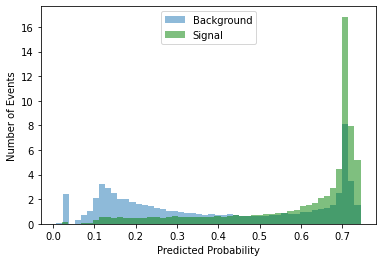

In [47]:
print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5, density=True)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, density=True, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
#plt.ylim(top=100)
plt.show()

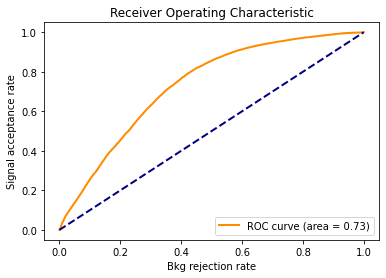

In [50]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Bkg rejection rate')
plt.ylabel('Signal acceptance rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
plt.show()

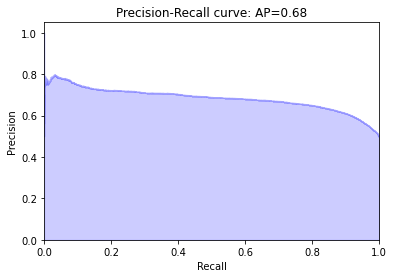

In [49]:
### precision recall curve
# Calculate precision-recall curve and average precision
precision, recall, _ = precision_recall_curve(y_test, predictions)
average_precision = average_precision_score(y_test, predictions)

# Plot precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [ ]:
target = torch.from_numpy(y_test.flatten())
pred = torch.from_numpy(predictions.flatten())

In [ ]:
metric = BinaryConfusionMatrix(threshold=0.5, normalize = 'true')(pred, target)

In [ ]:
metric